HW9

1) How are the initial conditions chosen and what geological features do they represent?

The initial conditions appear to be randomly chosen. With 10 

In [2]:
## Import necessary packages

%matplotlib inline 
# On Macs use osx
# For Windows use qt

import numpy as np
from numpy.random import rand
from landscapeWithOcean import LandscapeWithOcean # Import methods from inside file landscapeWithOcean.py

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
def AddHill(Z,NX,NY,xx,yy,r,h):

    for x in range(NX):
        for y in range(NY):
            dx = np.mod(x-xx+NX/2,NX)-NX/2; # difference i-i0 but apply p.b.c. 
            dy = np.mod(y-yy+NY/2,NY)-NY/2;
            dr = np.sqrt(dx**2+dy**2);
            if (dr<r):
                Z[x,y] += h * (np.cos(dr/r*np.pi/2.0))**2;

    return Z

In [4]:
### Define simulation grid and initial conditions

NX = 70*2 #number of rows
NY = 70*2 #number of columns

d  = 5 # grid spacing in meters
dx = d # keep dx=dy for simplicity
dy = d

LX=NX*dx
LY=NY*dy

# small random features in topography to begin erosion
Z = rand(NX,NY)*0.1
for i in range(5):
    xx = rand()*NX
    yy = rand()*NY
    r  = (0.1+rand())*NX
    h  = (0.1+rand())*5
    Z = AddHill(Z,NX,NY,xx,yy,r,h)

for i in range(5):
    xx = rand()*NX
    yy = rand()*NY
    r  = (0.1+rand())*NX/2
    h  = (0.5+rand())*10
    Z = AddHill(Z,NX,NY,xx,yy,r,h)

x = np.arange(NX)
y = np.arange(NY)
X,Y = np.meshgrid(y,x) #strange that y goes first !!!
ZMaxOrg = np.max(Z)
#print(ZMaxOrg)

In [5]:
### Physical Parameters
K = 1.0e-6 # meters^(1-2m)/yr

D = 0.005 # m^2/yr

# uplift rate
# uplift = 0.03 / 600.
uplift = 0.0

In [6]:
### Model parameters

# Time step
dt = d**2 / D / 8. 
#dt = d**2 / D /16. #extra small steps 
print(' dt[years] = ',dt)

#Area exponent A^m, default m=1
m=1

#gradient exponent g^n, default n=1
n=1

#erosion threshold 
theta_c = 10 

 dt[years] =  625.0


In [7]:
# Total simulation time
T = 1000.0 * 625.0

# total number of iterations
n_iter = int(np.round(T/dt))
print('Number of interation: ',n_iter)

Number of interation:  1000


In [8]:
# Initialize landscape 
ls = LandscapeWithOcean(NX,NY)

oceanLevelParameter=0.1  # what does this parameter do?
ls.ComputeOceanVolumeFromOceanLevelParameter(Z,NX,NY,oceanLevelParameter)

ls.pool_check(Z,NX,NY)
ls.A = np.zeros((NX,NY))

Minimum elevation           3.565818616598708
Maximum elevation           21.81648918283972
Beach level                 5.390885673222809
Ocean volume                916.6369264199061
Percentage of ocean surface 5.806122448979592


In [10]:
# Set-up figure
def init_figure():
    fig = plt.figure(figsize=(12.,6.))
    plt.show()
    return fig

def update_figure():
        plt.clf()
        ax1 = fig.add_subplot(121,projection='3d')

        # use equal x-y aspect with an explicit vertical exageration
        vert_exag = 4.
        ax1.set_xlim3d(0,max(NX,NY))
        ax1.set_ylim3d(0,max(NX,NY))
        ax1.set_zlim3d(0,ZMaxOrg)

        ax1.set_title('Surface Relief')

#        surf = ax1.plot_surface(X,Y,Z, cmap = cm.terrain, rstride=1, cstride=1,
#                antialiased=False,linewidth=0)

        ZPlot = np.copy(Z)
        ZPlot[ZPlot<ls.ZBeachLevel] = ls.ZBeachLevel 
        ZPlot -= ls.ZBeachLevel
        ax1.plot_surface(X,Y,ZPlot, cmap = cm.terrain, rstride=1, cstride=1,
                antialiased=False,linewidth=0)

        ax2 = fig.add_subplot(122,aspect='equal')
        ax2.set_title('Elevation')

        #im = ax2.pcolor(Z,cmap=cm.terrain)
        im = ax2.pcolor(ZPlot,cmap=cm.coolwarm)
        cs = ax2.contour(ZPlot,6,colors='k')

        # Add a color bar which maps values to colors.
        cbar = fig.colorbar(im, shrink=0.5, aspect=5)
        # Add the contour line levels to the colorbar
        cbar.add_lines(cs)

        #plt.show()
        plt.draw()
        plt.pause(0.0001)

In [11]:
# Set up figure
fig = init_figure()
update_figure()
Znew = np.copy(Z)

for it in range(1,n_iter+1):
    
    ls.calculate_collection_area(Z,NX,NY)
    ls.A *= dx*dy
    
    for i in range(NX):
        iL = np.mod(i-1,NX) # normally i-1 but observe p.b.c.
        iR = np.mod(i+1,NX) # normally i+1 but observe p.b.c.

        for j in range(NY):
            jD = np.mod(j-1,NY) # normally j-1 but observe p.b.c.
            jU = np.mod(j+1,NY) # normally j+1 but observe p.b.c.
  
            if ls.ocean[i,j]>0:
                Psi_z  = 0;
                Phi_z  = 0;
            else:
                if ls.drain[i,j]>0: #this cell is a drain
                    s1 = (Z[iR,j]  - Z[iL,j] )/(2.*dx)
                    s2 = (Z[i,jU]  - Z[i,jD] )/(2.*dy)
                    s3 = (Z[iR,jD] - Z[iL,jU])/(2. * np.sqrt( dx**2 + dy**2) )
                    s4 = (Z[iR,jU] - Z[iL,jD])/(2. * np.sqrt( dx**2 + dy**2) )
                    gradient = (np.sqrt(s1**2 + s2**2) + np.sqrt(s3**2 + s4**2))/2.
                    Psi_z = K * ( ls.A[i,j]**m * gradient**n - theta_c)            

                elif ls.drainage[i,j]>0: #this cell is a drainage point (it drains a pool)
                
                    if (Z[i,j]>=Z[iR,j]) and ls.pool[iR,j]!=ls.drainage[i,j]: 
                        gradient = (Z[i,j]-Z[iR,j])/dx #pool is on my left, I drain to the right, use this gradiant
                    elif (Z[i,j]>=Z[iL,j]) and ls.pool[iL,j]!=ls.drainage[i,j]:
                        gradient = (Z[i,j]-Z[iL,j])/dx
                    elif (Z[i,j]>=Z[i,jU]) and ls.pool[i,jU]!=ls.drainage[i,j]:
                        gradient = (Z[i,j]-Z[i,jU])/dy
                    elif (Z[i,j]>=Z[i,jD]) and ls.pool[i,jD]!=ls.drainage[i,j]:
                        gradient = (Z[i,j]-Z[i,jD])/dy
                    else:
                        gradient = 0.02 # ??? This does happen (maybe when two pools merge)
                    Psi_z = K * ( ls.A[i,j]**m * gradient**n - theta_c)
                
                else: #this cell is a pool, assume it has some mass diffusion but no erosion!
                    Psi_z = 0.
                
                if (Psi_z<0):
                    Psi_z = 0. 

                # diffusion term
                Phi_z = D * ( (Z[iR,j] - 2.*Z[i,j] + Z[iL,j]) / dx**2 \
                            + (Z[i,jU] - 2.*Z[i,j] + Z[i,jD]) / dx**2 )
           
            Znew[i,j] = Z[i,j] + (Phi_z - Psi_z + uplift )*dt  

            dZdt= (Znew[i,j] - Z[i,j]) / dt
            CFL = abs(dZdt) * dt / min(dx,dy)
            if (CFL>1.0):
                print('\nWarning: Time step of',dt,'is probably too large. Safer would be:',dt/CFL)
            
            if (Znew[i,j]<0.):
                Znew[i,j] = 0. # yes, this does happen at the boundary when kept at zero
    
    #Znew[0,:] = 0.0 # resets front boundary to 0
    Z = np.copy(Znew)
    
    ls.pool_check(Z,NX,NY)

    if (np.mod(it,10)==0): 
        print(it,end='')
        update_figure()
        print(' Ocean level=',ls.ZBeachLevel,' Ocean surface fraction=',100*ls.AOcean/(NX*NY));
    else:
        print('.',end='')

update_figure()
print(' Simulation finished.')


<Figure size 1200x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

..
.
......

KeyboardInterrupt: 

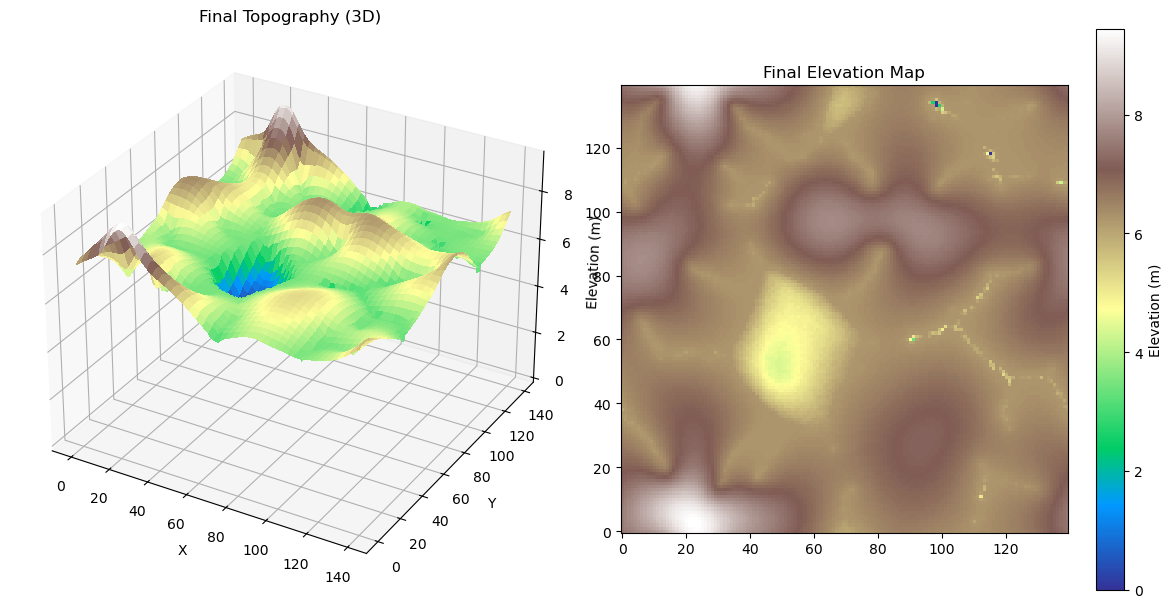

In [14]:
# --- Final visualization ---
plt.figure(figsize=(12,6))

# 3D surface plot
ax1 = plt.subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap=cm.terrain, linewidth=0, antialiased=False)
ax1.set_title('Final Topography (3D)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Elevation (m)')

# 2D elevation map
ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(Z, cmap=cm.terrain, origin='lower')
ax2.set_title('Final Elevation Map')
plt.colorbar(im, ax=ax2, label='Elevation (m)')

plt.tight_layout()
plt.show()


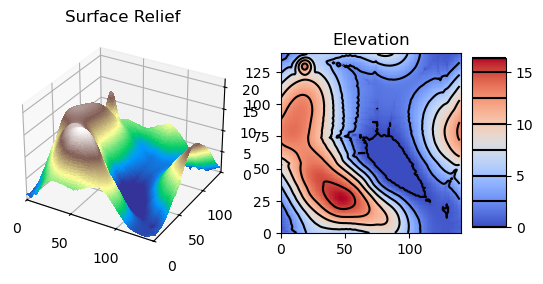

.........10 .........20 .........30 .........40 .........50 .........60 .........70 .........80 .........90 .........100 .........110 .........120 .........130 .........140 .........150 .........160 .........170 .........180 .........190 .........200 .........210 .........220 .........230 .........240 .........250 .........260 .........270 .........280 .........290 .........300 .........310 .........320 .........330 .........340 .........350 .........360 .........370 .........380 .........390 .........400 .........410 .........420 .........430 .........440 .........450 .........460 .........470 .........480 .........490 .........500 .........510 .........520 .........530 .........540 .........550 .........560 .........570 .........580 .........590 .........600 .........610 .........620 .........630 .........640 .........650 .........660 .........670 .........680 .........690 .........700 .........710 .........720 .........730 .........740 .........750 .........760 .........770 ........

<Figure size 640x480 with 0 Axes>


Simulation finished.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# -------------------------------
# Setup figure and arrays
# -------------------------------
fig, ax = plt.subplots()
im = ax.imshow(Z, cmap='terrain', origin='lower')
plt.colorbar(im, ax=ax, label='Elevation')

frames = []       # store snapshots every N steps
save_every = 10   # record every 10 iterations

Znew = np.copy(Z)
update_figure()

# -------------------------------
# Main simulation loop
# -------------------------------
for it in range(1, n_iter+1):
    ls.calculate_collection_area(Z, NX, NY)
    ls.A *= dx * dy

    for i in range(NX):
        iL = np.mod(i-1, NX)
        iR = np.mod(i+1, NX)
        for j in range(NY):
            jD = np.mod(j-1, NY)
            jU = np.mod(j+1, NY)

            if ls.ocean[i,j] > 0:
                Psi_z = 0.
                Phi_z = 0.
            else:
                if ls.drain[i,j] > 0:
                    s1 = (Z[iR,j] - Z[iL,j]) / (2.*dx)
                    s2 = (Z[i,jU] - Z[i,jD]) / (2.*dy)
                    s3 = (Z[iR,jD] - Z[iL,jU]) / (2.*np.sqrt(dx**2 + dy**2))
                    s4 = (Z[iR,jU] - Z[iL,jD]) / (2.*np.sqrt(dx**2 + dy**2))
                    gradient = (np.sqrt(s1**2 + s2**2) + np.sqrt(s3**2 + s4**2)) / 2.
                    Psi_z = K * (ls.A[i,j]**m * gradient**n - theta_c)
                elif ls.drainage[i,j] > 0:
                    if (Z[i,j]>=Z[iR,j]) and ls.pool[iR,j]!=ls.drainage[i,j]:
                        gradient = (Z[i,j]-Z[iR,j])/dx
                    elif (Z[i,j]>=Z[iL,j]) and ls.pool[iL,j]!=ls.drainage[i,j]:
                        gradient = (Z[i,j]-Z[iL,j])/dx
                    elif (Z[i,j]>=Z[i,jU]) and ls.pool[i,jU]!=ls.drainage[i,j]:
                        gradient = (Z[i,j]-Z[i,jU])/dy
                    elif (Z[i,j]>=Z[i,jD]) and ls.pool[i,jD]!=ls.drainage[i,j]:
                        gradient = (Z[i,j]-Z[i,jD])/dy
                    else:
                        gradient = 0.02
                    Psi_z = K * (ls.A[i,j]**m * gradient**n - theta_c)
                else:
                    Psi_z = 0.

                if Psi_z < 0:
                    Psi_z = 0.

                Phi_z = D * ((Z[iR,j] - 2.*Z[i,j] + Z[iL,j]) / dx**2 +
                             (Z[i,jU] - 2.*Z[i,j] + Z[i,jD]) / dy**2)

            Znew[i,j] = Z[i,j] + (Phi_z - Psi_z + uplift)*dt

            if Znew[i,j] < 0.:
                Znew[i,j] = 0.

    Z = np.copy(Znew)
    ls.pool_check(Z, NX, NY)

    # Save frame
    if it % save_every == 0:
        frames.append(Z.copy())

    if np.mod(it,10)==0:
        print(it, end=' ')
        im.set_data(Z)
        plt.pause(0.001)
    else:
        print('.', end='')

update_figure()
print('\nSimulation finished.')

# -------------------------------
# Create Animation
# -------------------------------
def animate(k):
    im.set_data(frames[k])
    ax.set_title(f'Iteration {k*save_every}')
    return [im]

anim = FuncAnimation(fig, animate, frames=len(frames), interval=100)

# Save as MP4 or GIF
anim.save('terrain_evolution.mp4', writer='ffmpeg', fps=10)
# OR:
# anim.save('terrain_evolution.gif', writer=PillowWriter(fps=10))

plt.show()
